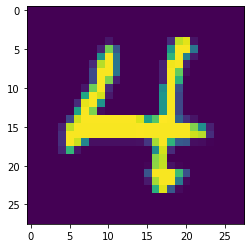

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])
X_train.shape, y_train.shape

# randomly select an MNIST figure and plot it
num_of_images = X_train.shape[0]
random_idx = np.random.randint(num_of_images)
plt.imshow(X_train.values[random_idx].reshape(28,28))

In [2]:
# generate biexponential parameters
def generate_params(image):
    #generate random lifetime values for the 28x28 binary image, each pixel was assigned 4 values at random, short-lifetime(tau1), long-lifetime(tau2), fractional amplitude(A1, A2)
    m = image.shape[0]
    n = image.shape[1]
    
    #tau1 values between 0.4-0.7ns, tau2 values between 2-3ns, A1 and A2 values between 0-1
    tau1_threshold = np.random.rand(m,n) * 0.3 + 0.4
    tau2_threshold = np.random.rand(m,n) * 1 + 2
    tau1 = tau1_threshold * image;
    tau2 = tau2_threshold * image;
    a1 = np.random.rand(m, n) * image;
    a2 = np.random.rand(m, n) * image;
    return tau1, tau2, a1,a2

# generate Intensity
def generate_intensity(image):
    #generate random intensity values for the 28x28 binary image
    m = image.shape[0]
    n = image.shape[1]
    
    #photon count values between 250-1500 p.c.
    intensity_threshold = np.random.rand(m, n) * 1250 + 250
    intensity = intensity_threshold * image
    return intensity

# performs convolution
def conv(a,b):
    A = np.fft.fft(a)
    B = np.fft.fft(b)
    C = A * B
    return abs(np.fft.ifft(C)/np.sum(a))

In [3]:
def generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib):
    M = intensity.shape[0]
    N = intensity.shape[1]
    #number of Time-Points
    nTP = 256
    time = np.arange(0,nTP,1)
    #dimension of one TPSF is image*time(28*28*nTP)
    voxel_data = np.zeros((M,N,nTP))
    irf = np.zeros((M,N,nTP))
    for i in range(M):
      for j in range(N):
        #generate fluorescence decays (Γ(𝑡)) at each nonzero pixel location
        if tau1[i,j]:
          decay = a1[i,j] * np.exp(-time.T/tau1[i,j]) + a2[i,j] * np.exp(-time.T/tau2[i,j])
          irf = irf_lib[:, np.random.randint(irf_lib.shape[1])]
          decay = conv(decay,irf/sum(irf))
          decay = decay * intensity[i,j]
          #assign the decay to its corresponding pixel location
          voxel_data[i,j,:] = decay / max(decay)
    return voxel_data

tau1 0.03689249818592435
tau2 0.15504863411686762
a1 0.033780367656885905
a2 0.002253623762701068 

tau1 0.06115610235980796
tau2 0.3340438224886063
a1 0.06303902481698209
a2 0.03221917065651422 



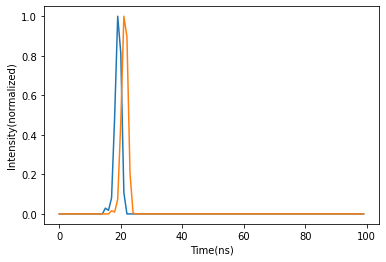

In [4]:
import scipy.io
mat = scipy.io.loadmat('FLIM_IRF.mat')
irf_lib = mat['irf_whole']

image = X_train.values[random_idx].reshape(28,28)
intensity = generate_intensity(image)
[tau1, tau2, a1, a2] = generate_params(image)
one_image_tpsfs = generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib)

#plot TPSF of the fist 2 nonezero pixels and print relevant parameters
def plot_pixel_TPSF():
    is_break = False
    n = 0
    for i in range(28):
      for j in range(28):
        if tau1[i,j]:
          time = np.arange(0,256,1)
          I = one_image_tpsfs[i, j, :]
          plt.plot(time[:100], I[:100])
          plt.xlabel('Time(ns)')
          plt.ylabel('Intensity(normalized)')
          print("tau1", tau1[i,j])
          print("tau2", tau2[i,j])
          print("a1", a1[i,j])
          print("a2", a2[i,j], '\n')
          n += 1
          if n == 2:
            is_break = True
        if is_break:
          break
      if is_break:
        break
plot_pixel_TPSF()

In [5]:
import scipy.io
mat = scipy.io.loadmat('FLIM_IRF.mat')
irf_lib = mat['irf_whole']
def generate_sample_input():
    input_voxels = []
    inten_vals = []
    tau1_vals = []
    tau2_vals = []
    a1_vals = []
    a2_vals = []
    random_num = np.random.randint(low=10000, high=12000)
    image = X_train.values[random_num].reshape(28,28)
    intensity = generate_intensity(image)
    [tau1, tau2, a1, a2] = generate_params(image)
    one_image_tpsfs = generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib)
    input_voxels.append(one_image_tpsfs)
    inten_vals.append(intensity)
    tau1_vals.append(tau1)
    tau2_vals.append(tau2)
    a1_vals.append(a1)
    a2_vals.append(a2)
    return np.array(input_voxels), np.array(inten_vals), np.array(tau1_vals), np.array(tau2_vals), np.array(a1_vals), np.array(a2_vals)

s_input_voxels, s_intensity, s_tau1, s_tau2, s_a1, s_a2 = generate_sample_input()

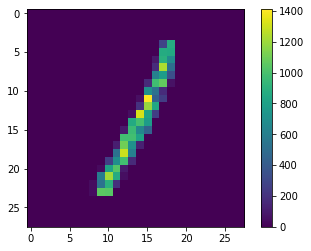

In [11]:
plt.imshow(s_intensity.reshape(28,28))
plt.colorbar()

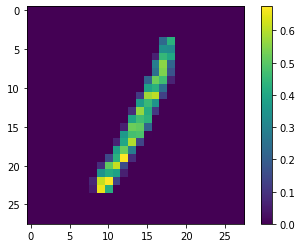

In [7]:
plt.imshow(s_tau1.reshape(28,28))
plt.colorbar()

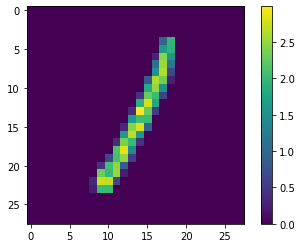

In [8]:
plt.imshow(s_tau2.reshape(28,28))
plt.colorbar()

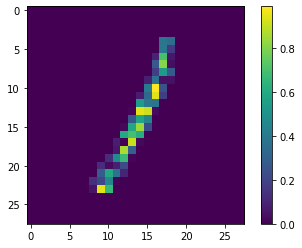

In [9]:
plt.imshow(s_a1.reshape(28,28))
plt.colorbar()

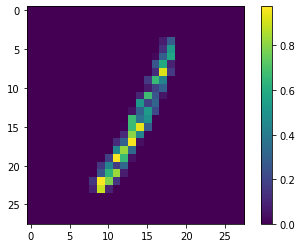

In [10]:
plt.imshow(s_a2.reshape(28,28))
plt.colorbar()

In [ ]:
import scipy.io
mat = scipy.io.loadmat('FLIM_IRF.mat')
irf_lib = mat['irf_whole']
def generate_a_small_training_set():
    input_voxels = []
    inten_vals = []
    tau1_vals = []
    tau2_vals = []
    a1_vals = []
    a2_vals = []
    for _ in range(2000):
      # num_of_images = X_train.shape[0]
      random_num = np.random.randint(5000)
      image = X_train.values[random_num].reshape(28,28)
      intensity = generate_intensity(image)
      [tau1, tau2, a1, a2] = generate_params(image)
      one_image_tpsfs = generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib)
      input_voxels.append(one_image_tpsfs)
      inten_vals.append(intensity)
      tau1_vals.append(tau1)
      tau2_vals.append(tau2)
      a1_vals.append(a1)
      a2_vals.append(a2)
    return np.array(input_voxels), np.array(inten_vals), np.array(tau1_vals), np.array(tau2_vals), np.array(a1_vals), np.array(a2_vals)

def generate_a_small_testing_set():
    input_voxels = []
    inten_vals = []
    tau1_vals = []
    tau2_vals = []
    a1_vals = []
    a2_vals = []
    for _ in range(2000,2400):
      random_num = np.random.randint(low=5000, high=10000)
      image = X_train.values[random_num].reshape(28,28)
      intensity = generate_intensity(image)
      [tau1, tau2, a1, a2] = generate_params(image)
      one_image_tpsfs = generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib)
      input_voxels.append(one_image_tpsfs)
      inten_vals.append(intensity)
      tau1_vals.append(tau1)
      tau2_vals.append(tau2)
      a1_vals.append(a1)
      a2_vals.append(a2)
    return np.array(input_voxels), np.array(inten_vals), np.array(tau1_vals), np.array(tau2_vals), np.array(a1_vals), np.array(a2_vals)

train_input_voxels, train_intensity, train_tau1, train_tau2, train_a1, train_a2 = generate_a_small_training_set()
test_input_voxels, test_intensity, test_tau1, test_tau2, test_a1, test_a2 = generate_a_small_testing_set()

#Introduce the channel dimention in the input dataset
xtrain = train_input_voxels[..., np.newaxis]
ytrain_tau1 = train_tau1[...,np.newaxis]
ytrain_tau2 = train_tau2[...,np.newaxis]
ytrain_a1 = train_a1[...,np.newaxis]
ytrain_a2 = train_a2[...,np.newaxis]

xtest = test_input_voxels[..., np.newaxis]
ytest_tau1 = test_tau1[...,np.newaxis]
ytest_tau2 = test_tau2[...,np.newaxis]
ytest_a1 = test_a1[...,np.newaxis]
ytest_a2 = test_a2[...,np.newaxis]

Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 256  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_2 (Conv3D)              (None, 28, 28, 247,  176         ['input_2[0][0]']                
                                 16)                                                              
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 28, 28, 247,  64         ['conv3d_2[0][0]']               
 rmalization)                    16)                                                          

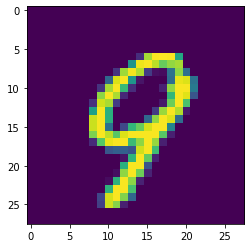

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Reshape
from keras import losses
from keras import metrics
from keras import optimizers 
#Define a convolutional neural network
def get_model():

    inputs = keras.Input((28, 28, 256, 1))

    x = Conv3D(filters=16, kernel_size=(1,1,10), activation="relu")(inputs)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    # x = Conv3D(filters=32, kernel_size=(1,1,10), activation="relu")(x)
    # # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    # x = BatchNormalization()(x)

    # x = Conv3D(filters=64, kernel_size=(1,1,10), activation="relu")(x)
    # # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    # x = BatchNormalization()(x)

    x = Conv3D(filters=32, kernel_size=(1,1,10), activation="relu")(x)
    # x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = BatchNormalization()(x)

    # x = GlobalAveragePooling3D()(x)
    # x = Dense(units=512, activation="relu")(x)
    # x = Dropout(0.3)(x)

    x = Reshape((28,28,-1))(x)

    t1 = Conv2D(filters =8, kernel_size = 1, activation="relu")(x)
    # t1 = MaxPooling2D(pool_size=(2, 2))(t1)
    t1 = BatchNormalization()(t1)
    t1 = Conv2D(1, 1, padding='same', activation=None)(t1)
    # t1 = BatchNormalization()(t1)
    # t1 = Conv2D(1, 1, padding='same', activation=None)(t1)


    t2 = Conv2D(filters =8, kernel_size = 1, activation="relu")(x)
    # t2 = MaxPooling2D(pool_size=(2, 2))(t2)
    t2 = BatchNormalization()(t2)
    t2 = Conv2D(1, 1, padding='same', activation=None)(t2)
    # t2 = BatchNormalization()(t2)
    # t2 = Conv2D(1, 1, padding='same', activation=None)(t2)

    a1 = Conv2D(filters =8, kernel_size = 1, activation="relu")(x)
    # a1 = MaxPooling2D(pool_size=(2, 2))(a1)
    a1 = BatchNormalization()(a1)
    a1 = Conv2D(1, 1, padding='same', activation=None)(a1)
    # a1 = BatchNormalization()(a1)
    # a1 = Conv2D(1, 1, padding='same', activation=None)(a1)

    a2 = Conv2D(filters =8, kernel_size = 1, activation="relu")(x)
    # a2 = MaxPooling2D(pool_size=(2, 2))(a2)
    a2 = BatchNormalization()(a2)
    a2 = Conv2D(1, 1, padding='same', activation=None)(a2)
    # a2 = BatchNormalization()(a2)
    # a2 = Conv2D(1, 1, padding='same', activation=None)(a2)

    # Define the model.
    model = keras.Model([inputs], [t1,t2,a1,a2], name="3dcnn")
    return model

# Build model.
model = get_model()
model.summary()

#training the model
model.compile(loss='mse',
              metrics=['mae'])

#fitting the model
history = model.fit(x=[xtrain], y=[ytrain_tau1,ytrain_tau2,ytrain_a1,ytrain_a2],
          batch_size = 20,
          epochs = 15,
          verbose = 1,
          validation_split=0.2)

In [ ]:
model.save("my_model_2000_15_changeloss")

INFO:tensorflow:Assets written to: my_model_2000_15_changeloss/assets


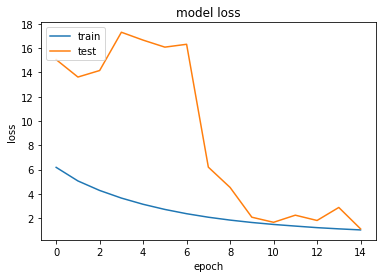

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def generate_predict_set():
    input_voxels = []
    inten_vals = []
    tau1_vals = []
    tau2_vals = []
    a1_vals = []
    a2_vals = []
    random_num = np.random.randint(low=10000, high=12000)
    image = X_train.values[random_num].reshape(28,28)
    intensity = generate_intensity(image)
    [tau1, tau2, a1, a2] = generate_params(image)
    one_image_tpsfs = generate_tpsf(intensity, tau1, tau2, a1, a2, irf_lib)
    input_voxels.append(one_image_tpsfs)
    inten_vals.append(intensity)
    tau1_vals.append(tau1)
    tau2_vals.append(tau2)
    a1_vals.append(a1)
    a2_vals.append(a2)
    return np.array(input_voxels), np.array(inten_vals), np.array(tau1_vals), np.array(tau2_vals), np.array(a1_vals), np.array(a2_vals)

predict_input_voxels, predict_intensity, predict_tau1, predict_tau2, predict_a1, predict_a2 = generate_predict_set()

In [ ]:
xpredict = predict_input_voxels[..., np.newaxis]
ypre_tau1 = predict_tau1[...,np.newaxis]
ypre_tau2 = predict_tau2[...,np.newaxis]
ypre_a1 = predict_a1[...,np.newaxis]
ypre_a2 = predict_a2[...,np.newaxis]

In [ ]:
score = model.evaluate([xtest], [ytest_tau1,ytest_tau2,ytest_a1,ytest_a2])

13/13 [==============================] - 16s 1s/step - loss: 1.1264 - conv2d_9_loss: 0.0908 - conv2d_11_loss: 0.6869 - conv2d_13_loss: 0.2027 - conv2d_15_loss: 0.1461 - conv2d_9_mae: 16.8060 - conv2d_11_mae: 78.9092 - conv2d_13_mae: 19.2757 - conv2d_15_mae: 12.9049


In [ ]:
print('loss:', score[0])

loss: 1.1264259815216064


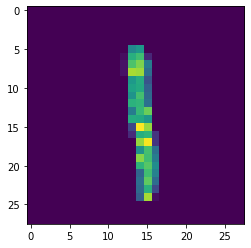

In [ ]:
#evaluating and printing results
results = model.predict(xpredict)
t1P = results[0]
t2P = results[1]
a1P = results[2]
a2P = results[3]
t1G = ypre_tau1
t2G = ypre_tau2
a1G = ypre_a1
a2G = ypre_a2
plt.imshow(t1G.reshape(28,28))

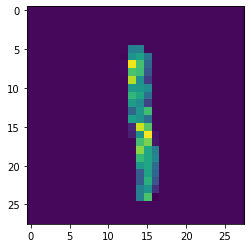

In [ ]:
plt.imshow(t1P.reshape(28,28))

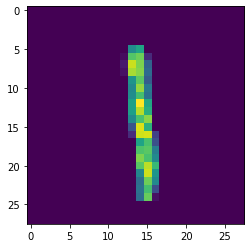

In [ ]:
plt.imshow(t2G.reshape(28,28))

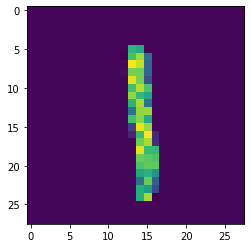

In [ ]:
plt.imshow(t2P.reshape(28,28))

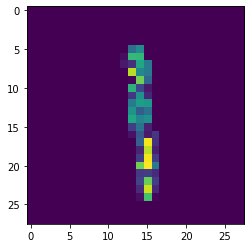

In [ ]:
plt.imshow(a1G.reshape(28,28))

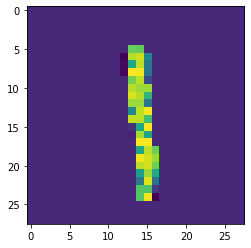

In [ ]:
plt.imshow(a1P.reshape(28,28))

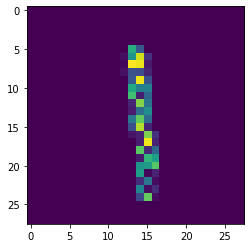

In [ ]:
plt.imshow(a2G.reshape(28,28))

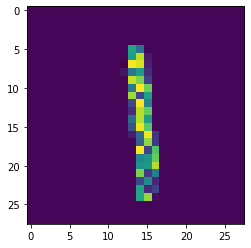

In [ ]:
plt.imshow(a2P.reshape(28,28))